In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import os
import tarfile
import urllib.request

# Step 1: Define URL and local paths
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = "flower_photos"
tgz_path = "flower_photos.tgz"

# Step 2: Download the dataset if not already downloaded
if not os.path.exists(tgz_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, tgz_path)
    print("Download completed!")

# Step 3: Extract the .tgz file
if not os.path.exists(dataset_dir):
    print("Extracting dataset...")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall()
    print("Extraction completed!")

# Step 4: Preview classes
print("Available classes:", os.listdir(dataset_dir))

Download completed!
Extracting dataset...


/tmp/ipython-input-962946542.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction completed!
Available classes: ['tulips', 'dandelion', 'daisy', 'sunflowers', 'roses', 'LICENSE.txt']


# Performing dataset split

In [15]:
import os, shutil
from sklearn.model_selection import train_test_split

original_dir = "flower_photos"
base_dir = "dataset"
os.makedirs(base_dir, exist_ok=True)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = os.listdir(class_path)
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for split, split_data in zip(["train", "val", "test"], [train, val, test]):
        split_path = os.path.join(base_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)
        for img in split_data:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

Dataset info with train, test & valid data

In [16]:
import os
from PIL import Image
from collections import defaultdict

def count_images_and_check_dims(root_dir):
    print(f"Scanning directory: {root_dir}")
    class_counts = defaultdict(int)
    dimensions = []

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    class_counts[class_name] += 1
                    dimensions.append(img.size + (len(img.getbands()),))  # (width, height, channels)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

    print("\n📊 Image Counts per Class:")
    for class_name, count in class_counts.items():
        print(f" - {class_name}: {count} images")


# Example usage:
print("=== Train Folder ===")
count_images_and_check_dims("dataset/train")

print("\n=== Validation Folder ===")
count_images_and_check_dims("dataset/val")

print("\n=== Test Folder ===")
count_images_and_check_dims("dataset/test")

=== Train Folder ===
Scanning directory: dataset/train

📊 Image Counts per Class:
 - tulips: 559 images
 - dandelion: 628 images
 - daisy: 443 images
 - sunflowers: 489 images
 - roses: 448 images

=== Validation Folder ===
Scanning directory: dataset/val

📊 Image Counts per Class:
 - tulips: 120 images
 - dandelion: 135 images
 - daisy: 95 images
 - sunflowers: 105 images
 - roses: 96 images

=== Test Folder ===
Scanning directory: dataset/test

📊 Image Counts per Class:
 - tulips: 120 images
 - dandelion: 135 images
 - daisy: 95 images
 - sunflowers: 105 images
 - roses: 97 images


In [9]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [10]:
from roboflow import Roboflow
rf = Roboflow(api_key = 'OW0NGyO0XjTOUAZ7RAiE')
project = rf.workspace("ayurved").project("ayurved")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ayurved-2 in folder:: 100%|██████████| 1725/1725 [00:00<00:00, 8250.12it/s]


# Setting the image directory paths with Data Augmentation

In [18]:
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

img_size = (224, 224)
batch_size = 64
num_classes = len(os.listdir(train_dir))

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=1, class_mode='categorical', shuffle=False)


Found 2567 images belonging to 5 classes.
Found 551 images belonging to 5 classes.
Found 552 images belonging to 5 classes.


# Defining the model architecture

In [19]:
base_model = VGG16(include_top = False, weights='imagenet', input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
for layer in base_model.layers:
  layer.trainable = False
  print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


In [22]:
base_model.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [23]:
base_model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation ='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training

In [26]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("vgg16_best_model_ayurved.keras", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2645 - loss: 5.5568 - val_accuracy: 0.6171 - val_loss: 1.4190
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 903ms/step - accuracy: 0.5017 - loss: 2.7467 - val_accuracy: 0.7205 - val_loss: 1.0783
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 908ms/step - accuracy: 0.6267 - loss: 1.9377 - val_accuracy: 0.7495 - val_loss: 0.9051
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 905ms/step - accuracy: 0.6715 - loss: 1.5261 - val_accuracy: 0.7731 - val_loss: 0.8360
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 895ms/step - accuracy: 0.7059 - loss: 1.3404 - val_accuracy: 0.7840 - val_loss: 0.7501
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 891ms/step - accuracy: 0.7372 - loss: 1.0932 - val_accuracy: 0.7985 - val_loss: 0.6930
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 886ms/step - accuracy: 0.7459 - loss: 0.9571 - val_accuracy: 0.8040 - val_loss: 0.6438
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 896ms/step - accuracy: 0.7750 - loss: 0.8228 - val_accurac

# Accuracy & Loss graphs

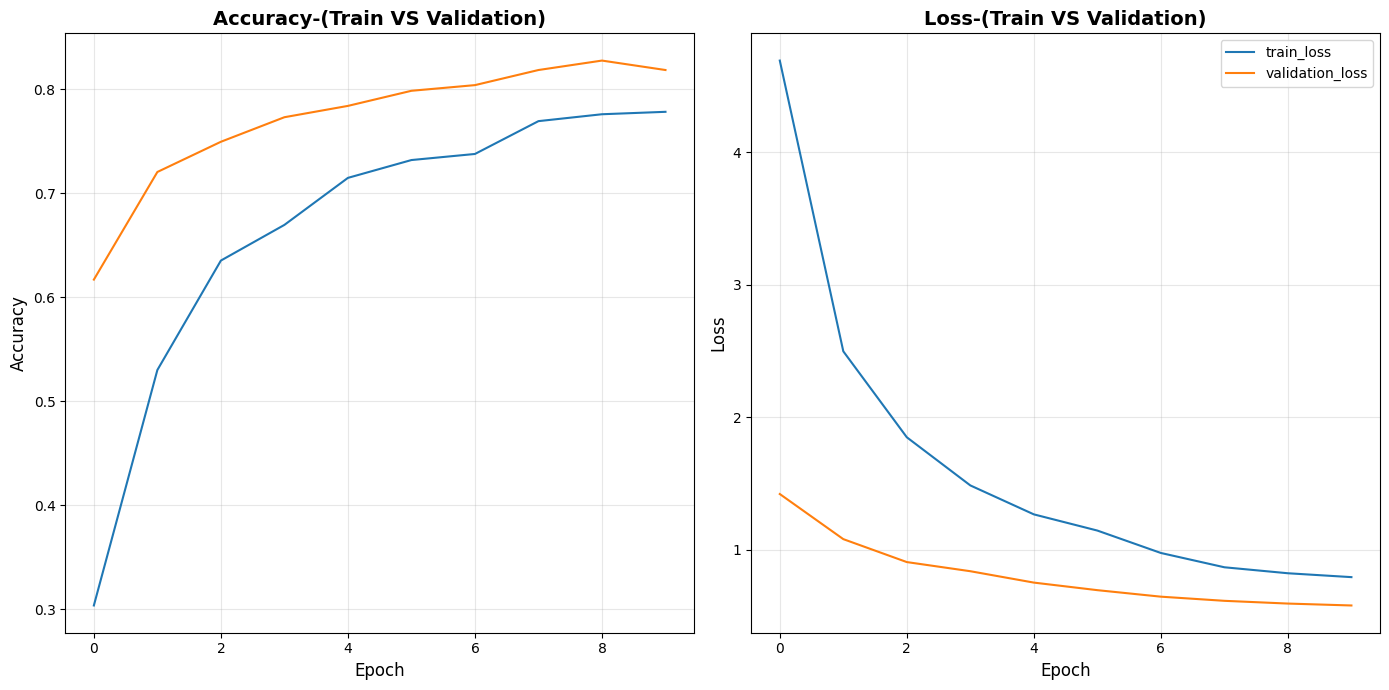

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Accuracy
ax1.plot(history.history['accuracy'], label='train_accuracy')
ax1.plot(history.history['val_accuracy'], label='validation_accuracy')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Accuracy-(Train VS Validation)", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='validation_loss')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("Loss-(Train VS Validation)", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

In [29]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy:{accuracy:.4f}")

552/552 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8646 - loss: 0.4909
Test Accuracy:0.8678


In [35]:
def predict_image(image_path):
  img = load_img(image_path, target_size=img_size)
  plt.imshow(img) # Display the image
  plt.axis('off') # Hide axes
  plt.show() # Show the image
  img_array = img_to_array(img)
  img_array = preprocess_input(np.expand_dims(img_array, axis=0))
  pred = model.predict(img_array)
  predicted_class = np.argmax(pred)
  class_names=list(train_generator.class_indices.keys())
  print(f"Predicted Class:{class_names[predicted_class]}")

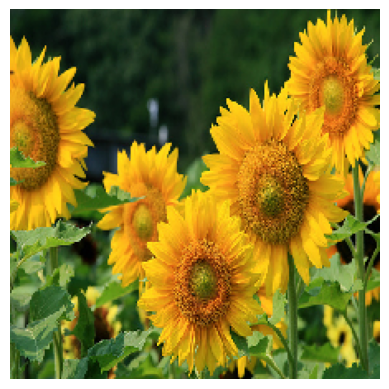

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicted Class:sunflowers


In [36]:
predict_image('/content/dataset/test/sunflowers/1008566138_6927679c8a.jpg')

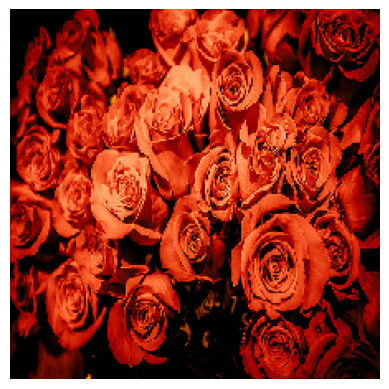

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Class:roses


In [37]:
predict_image("/content/dataset/test/roses/10503217854_e66a804309.jpg")

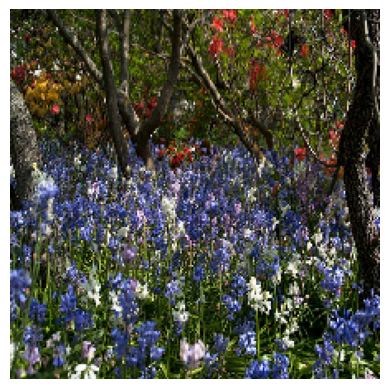

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Class:sunflowers


In [38]:
predict_image("/content/dataset/test/tulips/10094729603_eeca3f2cb6.jpg")

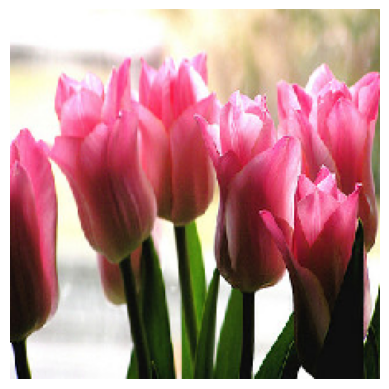

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class:tulips


In [39]:
predict_image("/content/dataset/test/tulips/112650879_82adc2cc04_n.jpg")